In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d
import pandas as pd
%matplotlib inline


In [2]:
def read_img(filename, convert_to_greyscale=False):
    image = cv2.imread(filename)
    if convert_to_greyscale:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return image, np.uint8(gray_image)

In [3]:
def read_video(filename, convert_to_greyscale=False):
    cap = VideoCapture(filename)
    ###TODO: Write read_video function
    
    return video_data

In [4]:
def save_img(filename, image):
    cv2.imwrite('Desktop/gray_image.png',image)

In [5]:
def change_plot_size(size):
    from pylab import rcParams
    rcParams['figure.figsize'] = size[0], size[1]

In [6]:
def Harris_detector_2D(filename, gaussian_kernel_size, sigma):
    ###---###
    image, gray_image = read_img(filename, True)
    first_image = image
    print first_image.shape
#    image = image.astype(float)
    image = cv2.GaussianBlur(gray_image, gaussian_kernel_size, sigmaX = sigma, sigmaY = sigma)
    im_size = image.shape
    Gy = np.zeros(im_size)
    Gxy = np.zeros(im_size)
    Gx = np.zeros(im_size)
    Gx = Gx.astype(float)
    print im_size
    vertical_derivative_kernel = np.array([[-1.0, -1.0, -1.0],
                              [0.0, 0.0, 0.0],
                              [1.0, 1.0, 1.0]]) / 6.0
    horizontal_derivative_kernel = np.array([[-1.0, 0.0, 1.0],
                              [-1.0, 0.0, 1.0],
                              [-1.0, 0.0, 1.0]]) / 6.0

    dy_img = cv2.filter2D(image,cv2.CV_64FC1, vertical_derivative_kernel)
    dx_img = cv2.filter2D(image,cv2.CV_64FC1, horizontal_derivative_kernel)
    print dx_img.shape, dy_img.shape
    for i in xrange(1, im_size[0] - 1):
        for j in xrange(1, im_size[1]- 1):            
            Gx[i, j] = dx_img[i, j] * dx_img[i, j]
            Gy[i, j] = dy_img[i, j] * dy_img[i, j]
            Gxy[i, j] =dx_img[i, j] * dy_img[i, j]

    #Gx = cv2.GaussianBlur(Gx, gaussian_kernel_size, sigma)    
    #Gy = cv2.GaussianBlur(Gy, gaussian_kernel_size, sigma)    
    #Gxy = cv2.GaussianBlur(Gxy, gaussian_kernel_size, sigma)    

    L = np.zeros(im_size)
    L = L.astype(float)
    for i in xrange(im_size[0]):
        for j in xrange(im_size[1]):
            m1 = Gx[i, j]
            m2 = Gxy[i, j]
            m3 = Gy[i, j]
            L[i][j] = abs(m1*m3 - m2*m2 - 0.04*(m1 + m3)*(m1 + m3));
    L *= 255.0/L.max()
    L = L.astype(int)
    
    thresholdMatrix = np.zeros(im_size)
    points = {}
    max_intensity = L.max()
    print "max_intensity =", max_intensity
    index = 0
    for i in xrange(im_size[0]):
        for j in xrange(im_size[1]):
            if (L[i][j] > max_intensity * 0.3):
                thresholdMatrix = L[i][j]
                points[i * im_size[1] + j] = L[i][j]
    
    
    interest_points, map_parents = fastRegionalMax(points, im_size)
    for point in interest_points:
        cv2.circle(first_image,(point % im_size[1], point / im_size[1]), 5, (0,0,255), -1)
    return first_image,image,dx_img, dy_img,  Gx, Gy, Gxy, L, points, interest_points, map_parents
    ###---###

In [7]:
def Harris_detector_3D(filename, gaussian_kernel_size, sigma):
    video_data = read_video(filename, True)
    
    video_data = GaussianBlur3D(video_data, gaussian_kernel_size, sigma)
    
    im_size = video_data.shape
    Gy = np.zeros(im_size)
    Gxy = np.zeros(im_size)
    Gx = np.zeros(im_size)



In [8]:
#t_copy = t
def GaussianBlur3D(data, kernel_size, sigma):
    t = data.copy()
    start = time.clock()
    
    for i in xrange(data.shape[0]):
        t2 = cv2.GaussianBlur(t[i], (1, kernel_size[2]), sigma)
        t[i] = t2

    for i in xrange(t.shape[1]):
        t2 = cv2.GaussianBlur(t[:, i, :], (kernel_size[0], 1), sigma)
        t[:, i, :] = t2

    for i in xrange(t.shape[2]):
        t2 = cv2.GaussianBlur(t[:, :, i], (1, kernel_size[1]), sigma)
        t[:, :, i] = t2
        
    finish = time.clock()
    print (finish - start)
    return t

In [9]:
def fastRegionalMax(points, im_size):
    #print points
    #print im_size
    init_dsu(len(points))
    shifts = [(-1, -1), (-1, 0), (0, -1)]
    map_parents = {}
    index = 0
    values = []
    
    
    cnt = 0
    for key in sorted(points.iterkeys()):
        #print point
        point = (key, points[key])
        map_parents[point[0]] = index
        values.append(point[1])
        index += 1
    
    for key in sorted(points.iterkeys()):
        point = (key, points[key])
        point_col = point[0] % im_size[1]
        point_row = point[0] / im_size[1]
        #values[point[0]] = point[1]
        
        for shift in shifts:
            newi = (point_row + shift[0])
            newj = (point_col + shift[1])
            neighbour = newi * im_size[1] + newj#(point_row + shift[0], point_col + shift[1])
            
            if newi < 0 or  newj < 0:
                continue
                
            if neighbour in points:
                #print point[0], neighbour
                new_set = map_parents[neighbour]
                if values[new_set] == point[1]:
                    cnt += 1
                    union_sets(map_parents[neighbour], map_parents[point[0]])
    print len(pd.unique(parent))
    print sorted(sz)[-20:]
    print "amount neighbours:", cnt 
    
    neighbours = []
    vicinity_x = [ -1, -1, -1, 
                    0,      0,
                    1,  1,  1 ]
    
    vicinity_y = [ -1,  0,  1,
                   -1,      1,
                   -1,  0,  1 ]
    
    for point in points:
        neighbours.append(set())
    cnt = 0
    cnt_diff_sets = 0
    for key in sorted(points.iterkeys()):
        point = (key, points[key])
        cur_set = find_set(map_parents[point[0]])
        row = point[0] / im_size[1]
        col = point[0] % im_size[1]
        for i in xrange(len(vicinity_x)):
            new_point = (row + vicinity_x[i]) * im_size[1] + col + vicinity_y[i]
            if ((row + vicinity_x[i]) < 0 or (row + vicinity_x[i]) > im_size[0]) or \
               ((col + vicinity_y[i]) < 0 or (col + vicinity_y[i]) > im_size[1]):
                    continue
                    
                    
            if new_point in map_parents:
                cnt += 1
                new_set = find_set(map_parents[new_point])
                if new_set != cur_set:
                    #print cur_set, new_set
                    cnt_diff_sets += 1
                    neighbours[cur_set].add(new_set)
                    neighbours[new_set].add(cur_set)
                    
    print "amount newighbours in points:", cnt
    print "amount diff sets:", cnt_diff_sets
    
    regMax = set()
    cnt_empty = 0
    cnt_reg_max = 0
    strt = 1000
    am_sets = 20
    for i in xrange(strt, strt+ 20):
        print i,parent[i], sorted(neighbours[parent[i]])
    
    
    for key in sorted(points.iterkeys()):
        point = (key, points[key])
        cur_set = find_set(map_parents[point[0]])
        
        #print point[0], neighbours[cur_set]

        if len(neighbours[cur_set]) == 0:
            cnt_empty+=1
            regMax.add(point[0])
        else:
            b = True
            for neighbour in sorted(neighbours[cur_set]):
                if values[neighbour] > values[cur_set]:
                    b = False
                    break
            if b:
                regMax.add(point[0])
                cnt_reg_max+=1
    print "cnt_empty = ", cnt_empty
    print "amount reg max points:", cnt_reg_max
    return regMax, map_parents
    
                

In [10]:
# dsu functions
def init_dsu(n):
    for i in xrange(n):
        parent.append(i)
        sz.append(1)

def find_set(x):
    if x == parent[x]:
        return x
    parent[x] = find_set(parent[x])
    return parent[x]

def union_sets(x, y):
    x1 = find_set(x)
    y1 = find_set(y)
    if x1 == y1:
        return
    if sz[x1] > sz[y1]:
        t = x1
        x1 = y1
        y1 = t
    parent[x1] = y1
    sz[y1] += sz[x1]
#    if sz[x] == sz[y]:
#        sz[y] += 1
    

# Test fastRegionalMax

In [329]:
matrix = np.array([[1, 0, 2, 3, 4, 2, 3, 1, 8, 7],
                   [1, 0, 9, 0, 4, 4, 3, 2, 8, 7],
                   [1, 1, 1, 0, 4, 4, 2, 8, 8, 8],
                   [0, 0, 0, 0, 3, 3, 3, 4, 8, 5]])
points = {}
for i in xrange(matrix.shape[0]):
    for j in xrange(matrix.shape[1]):
        points[i * matrix.shape[1] + j] = matrix[i][j]


In [330]:
parent = []
sz = []

rmax, mp = fastRegionalMax(points, matrix.shape)

cnt_empty =  0


In [331]:
rmax

{4, 8, 12, 14, 15, 18, 24, 25, 27, 28, 29, 38}

In [65]:
t = np.array([[[1, 2, 3], [4, 5, 6]] ,
     [[7, 8, 9], [10, 11, 12]],
    [[13, 14, 15], [16, 17, 18]], 
            [[19, 20, 21], [22, 23, 24]]])

In [72]:
t[0]

array([[1, 2, 3],
       [4, 5, 6]])

In [73]:
t[:, 0, :]

array([[ 1,  2,  3],
       [ 7,  8,  9],
       [13, 14, 15],
       [19, 20, 21]])

In [74]:
t[:, :, 0]

array([[ 1,  4],
       [ 7, 10],
       [13, 16],
       [19, 22]])

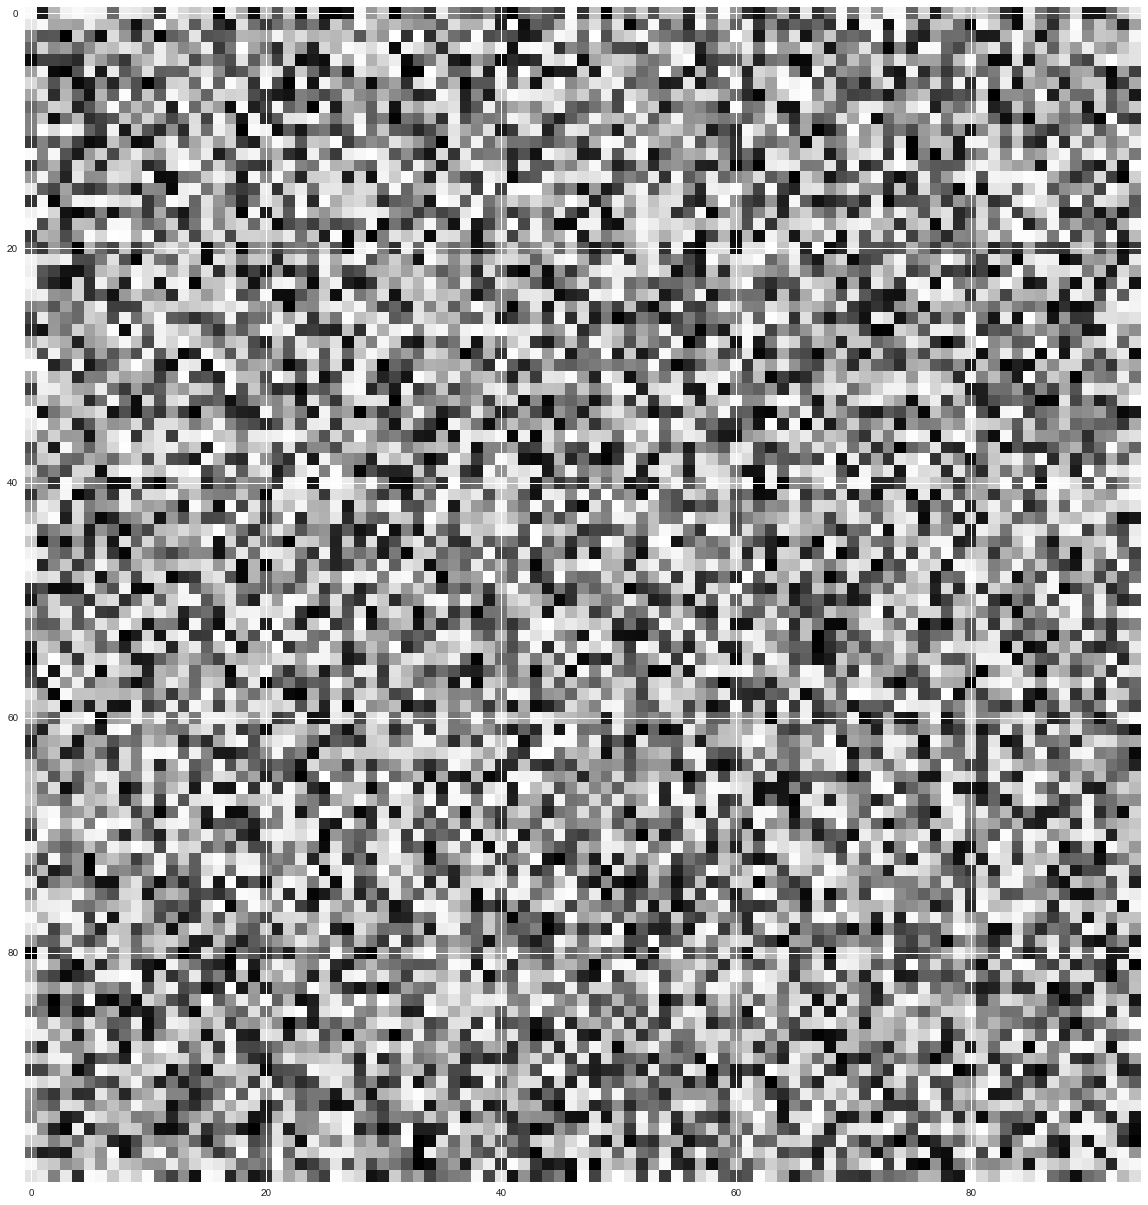

In [163]:
plt.imshow(t_copy[:, 0, :])

In [157]:
t_copy = t.copy()

In [71]:
t.T.shape

(3, 2, 4)

10 seconds video(60 frames/sec)<br>

- 144p(176×144) - 1.11
- 240p(320×240) - 3.09
- 480p(720×480) - 19.13
- 720p() - 
- 1080p() - 

In [175]:
t = []
for i in xrange(600):
    cur_frame = np.random.rand(720, 480)
    t.append(cur_frame)
t = np.array(t)
print (t.shape)

(600, 720, 480)


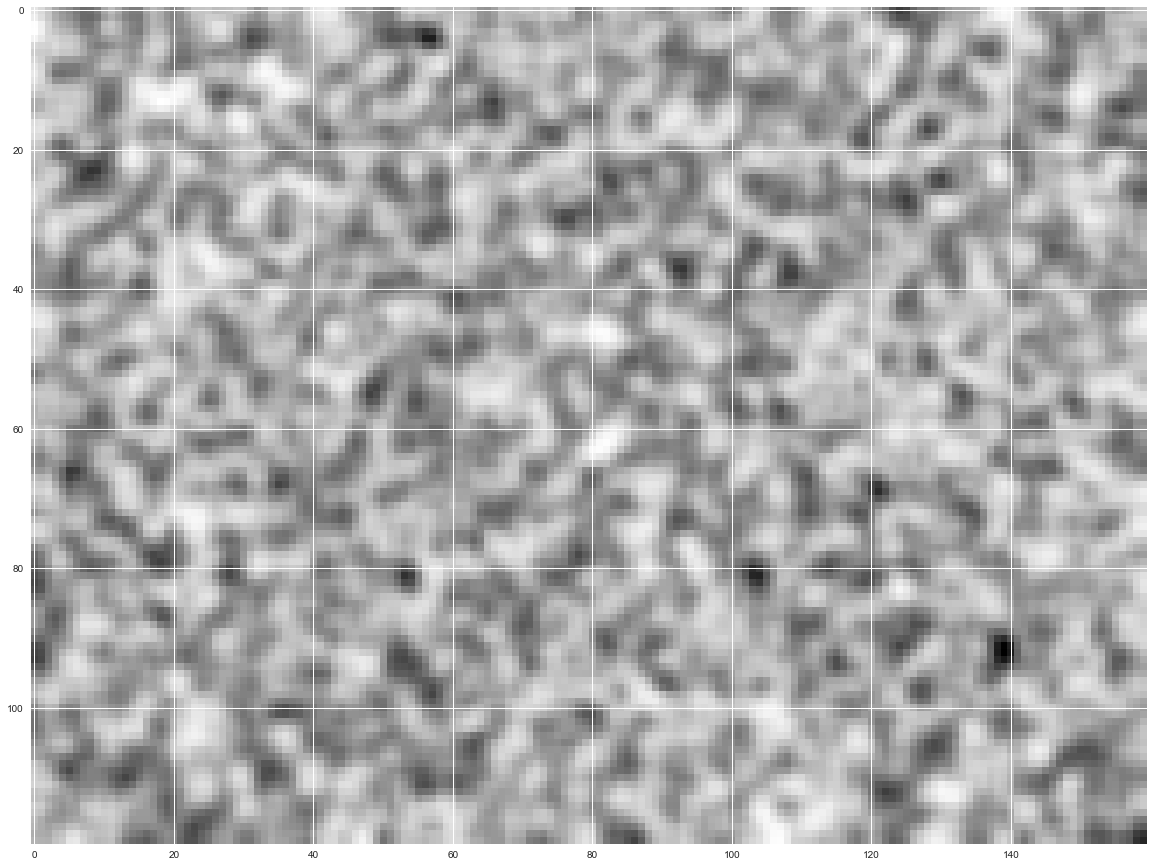

In [166]:
plt.imshow(t[0, :, :])

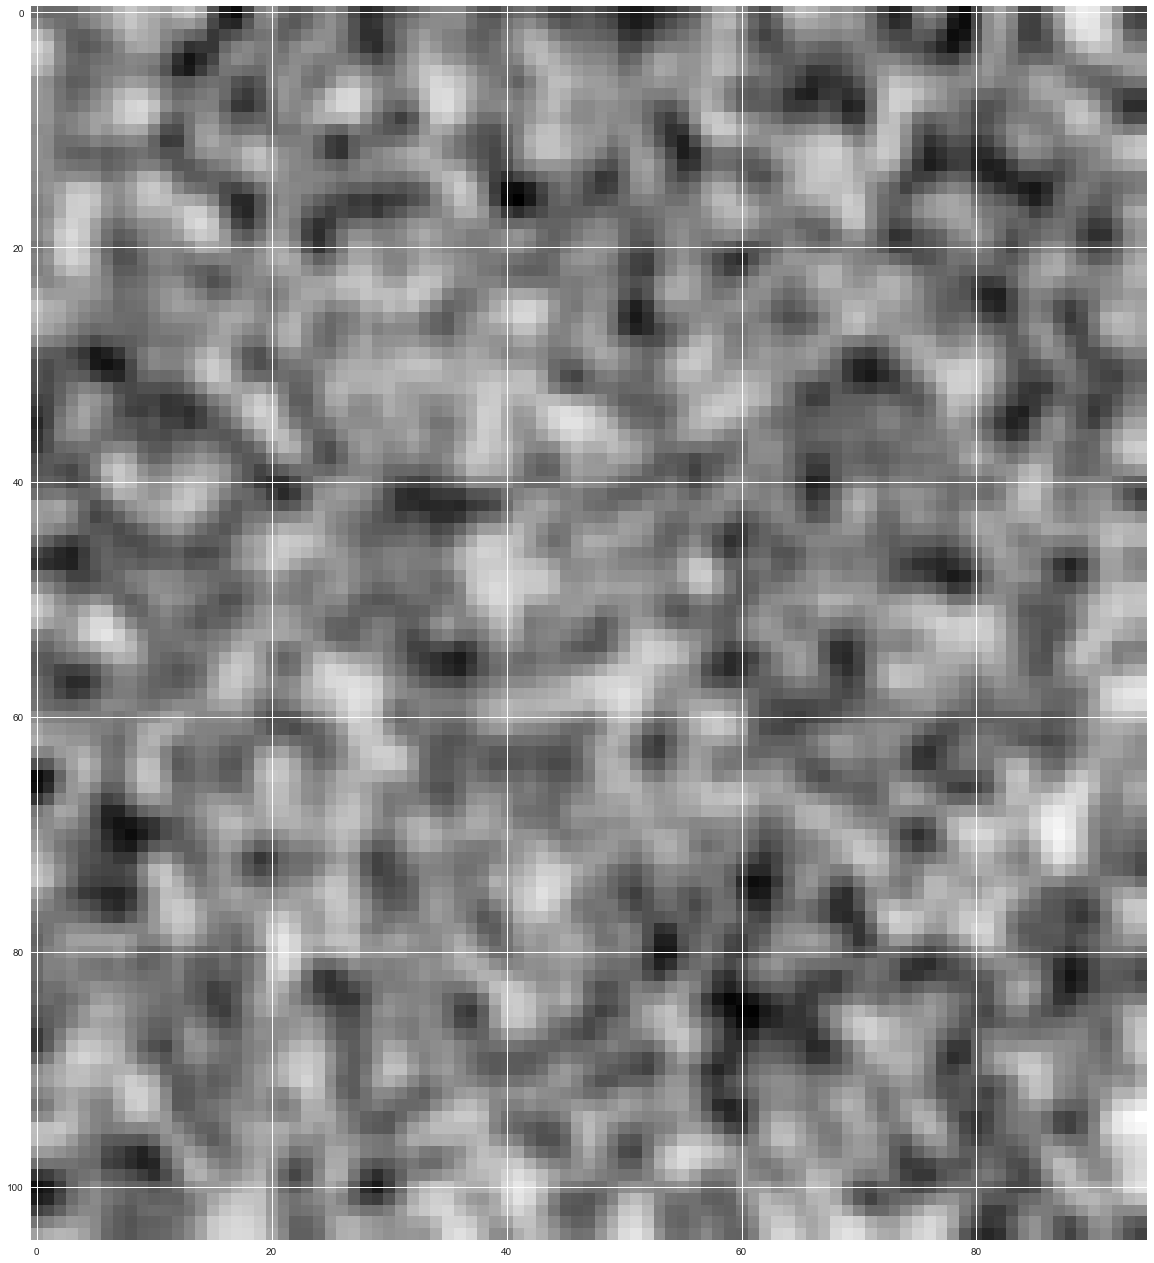

In [145]:
plt.imshow(t_copy[0, :, :])

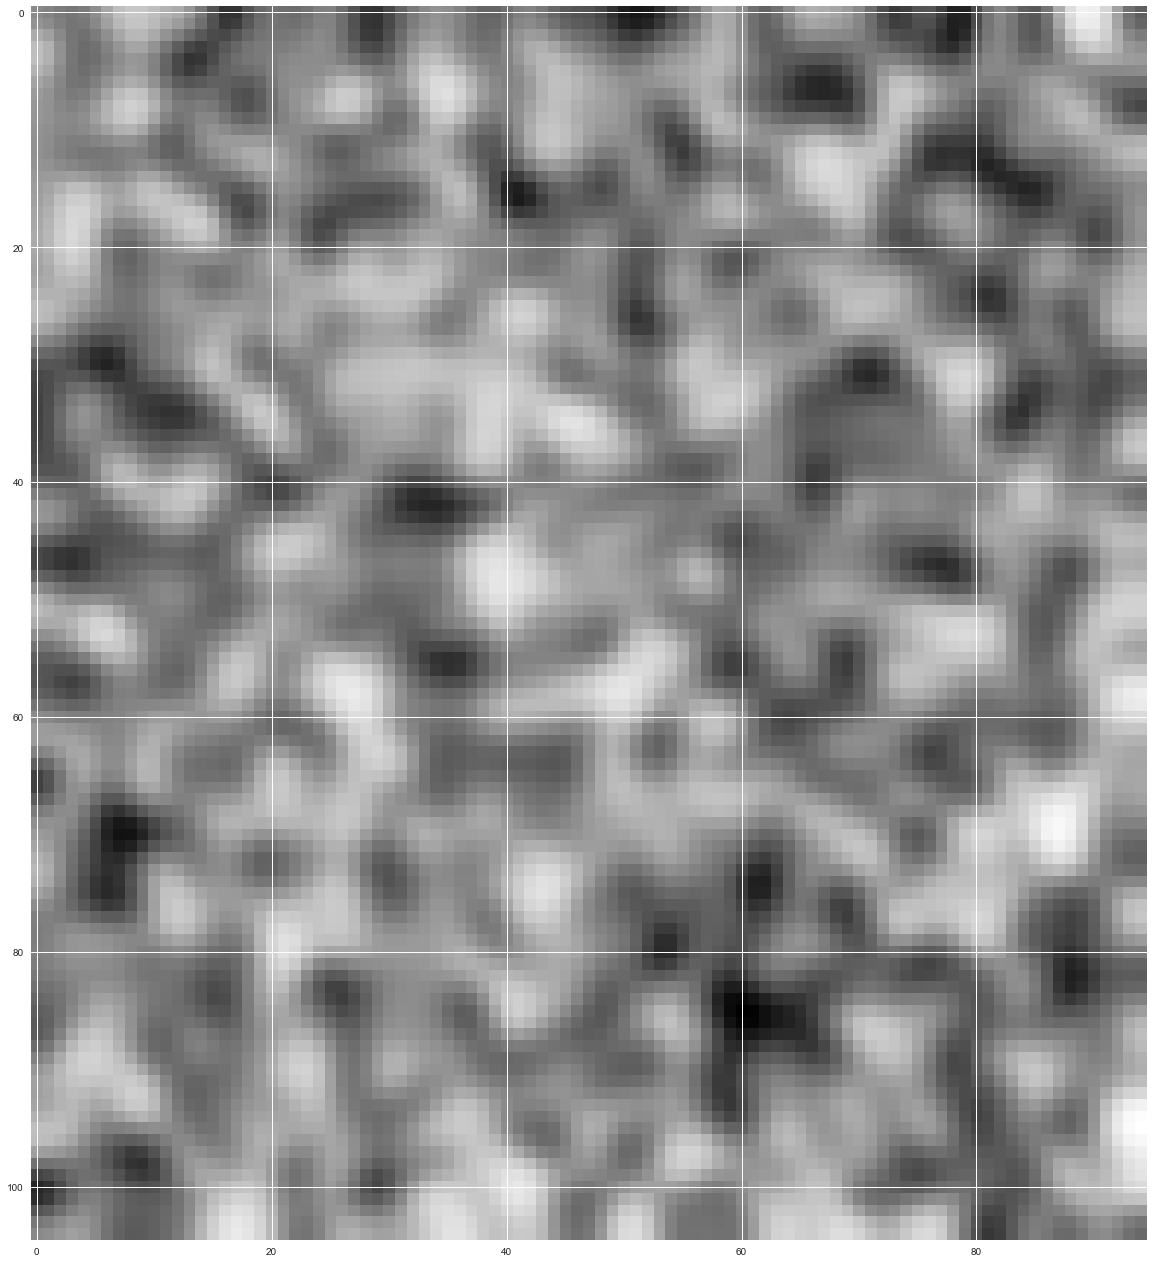

In [144]:
t1 = cv2.GaussianBlur(t_copy[0], (5, 5), sigmaX = 1.5, sigmaY = 1.5)

plt.imshow(t1)

In [113]:
t[i].shape

(105, 95)

In [108]:
print ("5")

5


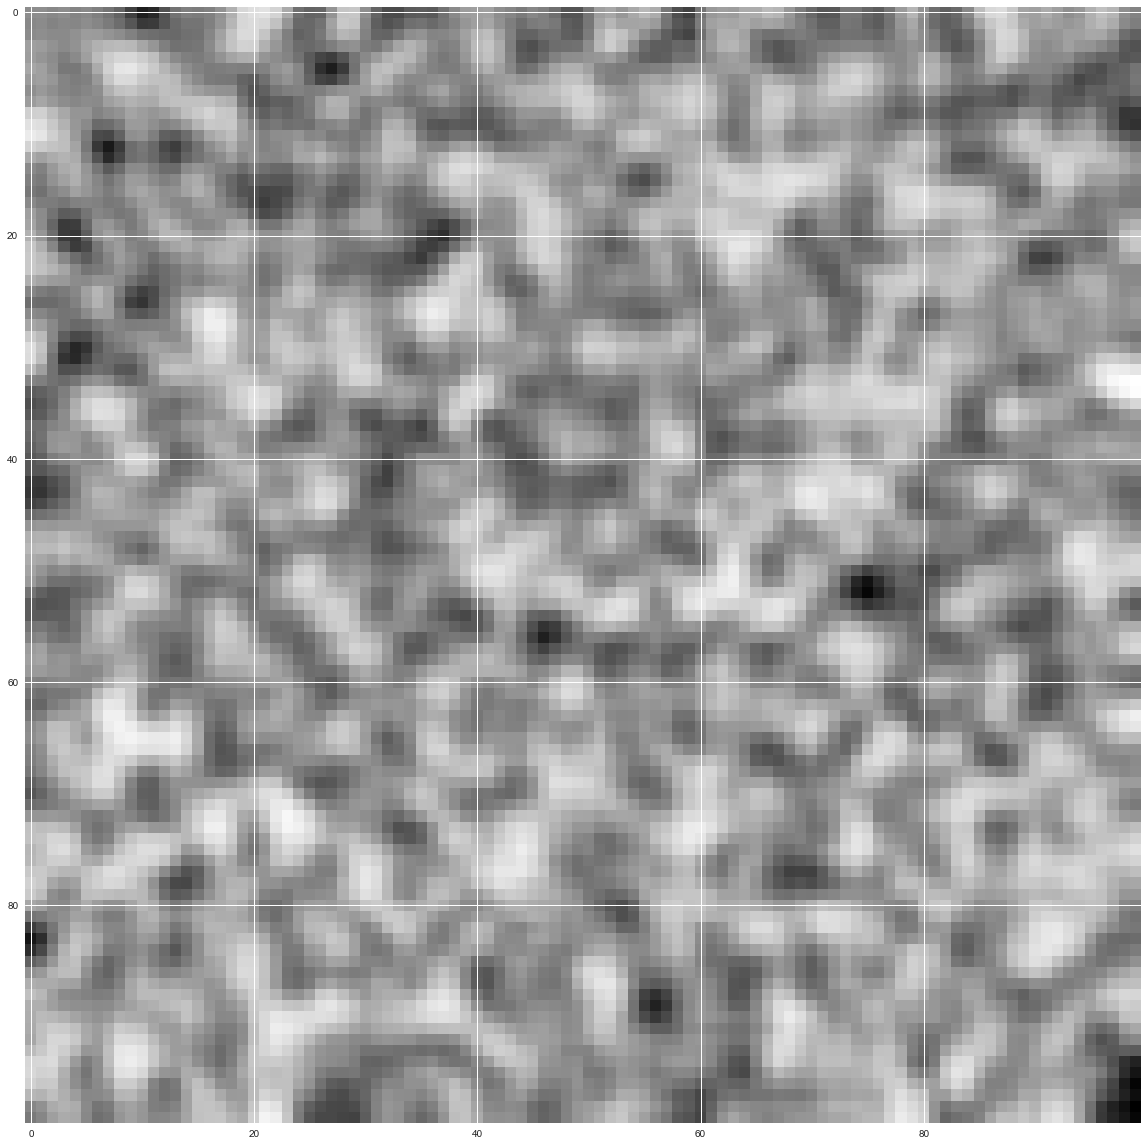

In [90]:
t2 = cv2.GaussianBlur(t[0], (5, 1), 1.5)
t2 = cv2.GaussianBlur(t2, (1, 5), 1.5)
plt.imshow(t2)

In [81]:
t = np.array(t)
t.shape

(100, 100, 100)

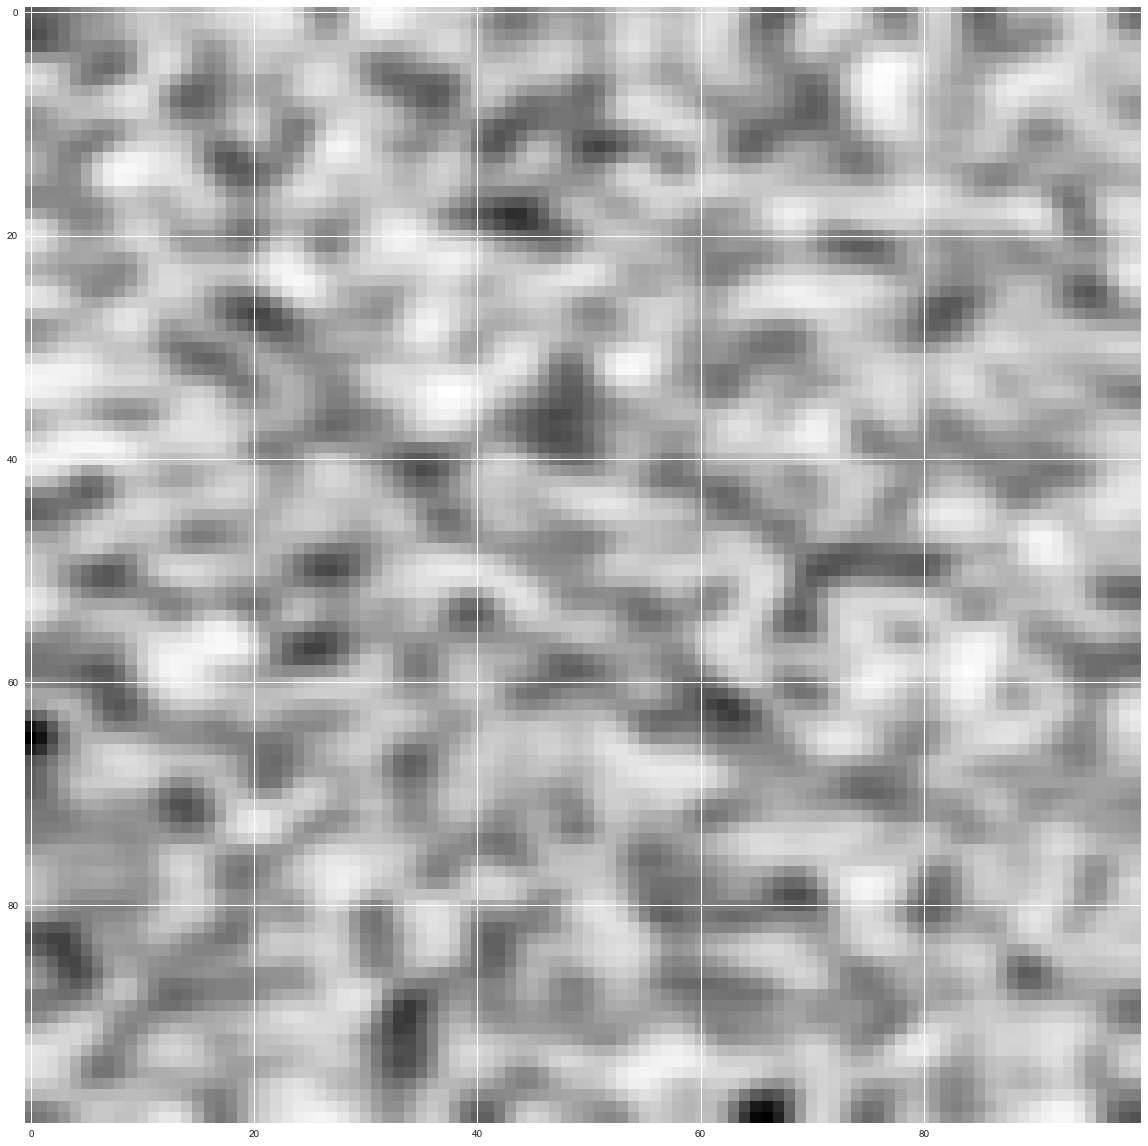

In [95]:
plt.imshow(t[:, :, 0])

# end Test fastRegionalMax

In [14]:
change_plot_size((20, 40))

(875, 800, 3)
(875, 800)
(875, 800) (875, 800)
max_intensity = 255
3385
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 20, 32, 87, 92, 179, 220, 223, 430, 865]
amount neighbours: 4423
amount newighbours in points: 24632
amount diff sets: 14100
1000 1000 [999, 1123]
1001 1001 [1125, 1126]
1002 1002 [1003, 1127]
1003 1003 [1002, 1004, 1127, 1128]
1004 1004 [1003, 1006, 1127, 1128, 1129]
1005 1006 [1004, 1008, 1128, 1129]
1006 1006 [1004, 1008, 1128, 1129]
1007 1006 [1004, 1008, 1128, 1129]
1008 1008 [1006, 1009]
1009 1009 [1008, 1010, 1130]
1010 1010 [1009, 1011, 1130, 1131]
1011 1011 [1010, 1130, 1131, 1132]
1012 1012 [1013, 1134, 1135, 1136]
1013 1013 [1012, 1135, 1136, 1137]
1014 1014 [1015, 1139]
1015 1015 [1014, 1016, 1139, 1140]
1016 1016 [1015, 1018, 1139, 1140, 1141]
1017 1018 [1016, 1019, 1140, 1141]
1018 1018 [1016, 1019, 1140, 1141]
1019 1019 [1018, 1020]
cnt_empty =  123
amount reg max points: 1716
1839


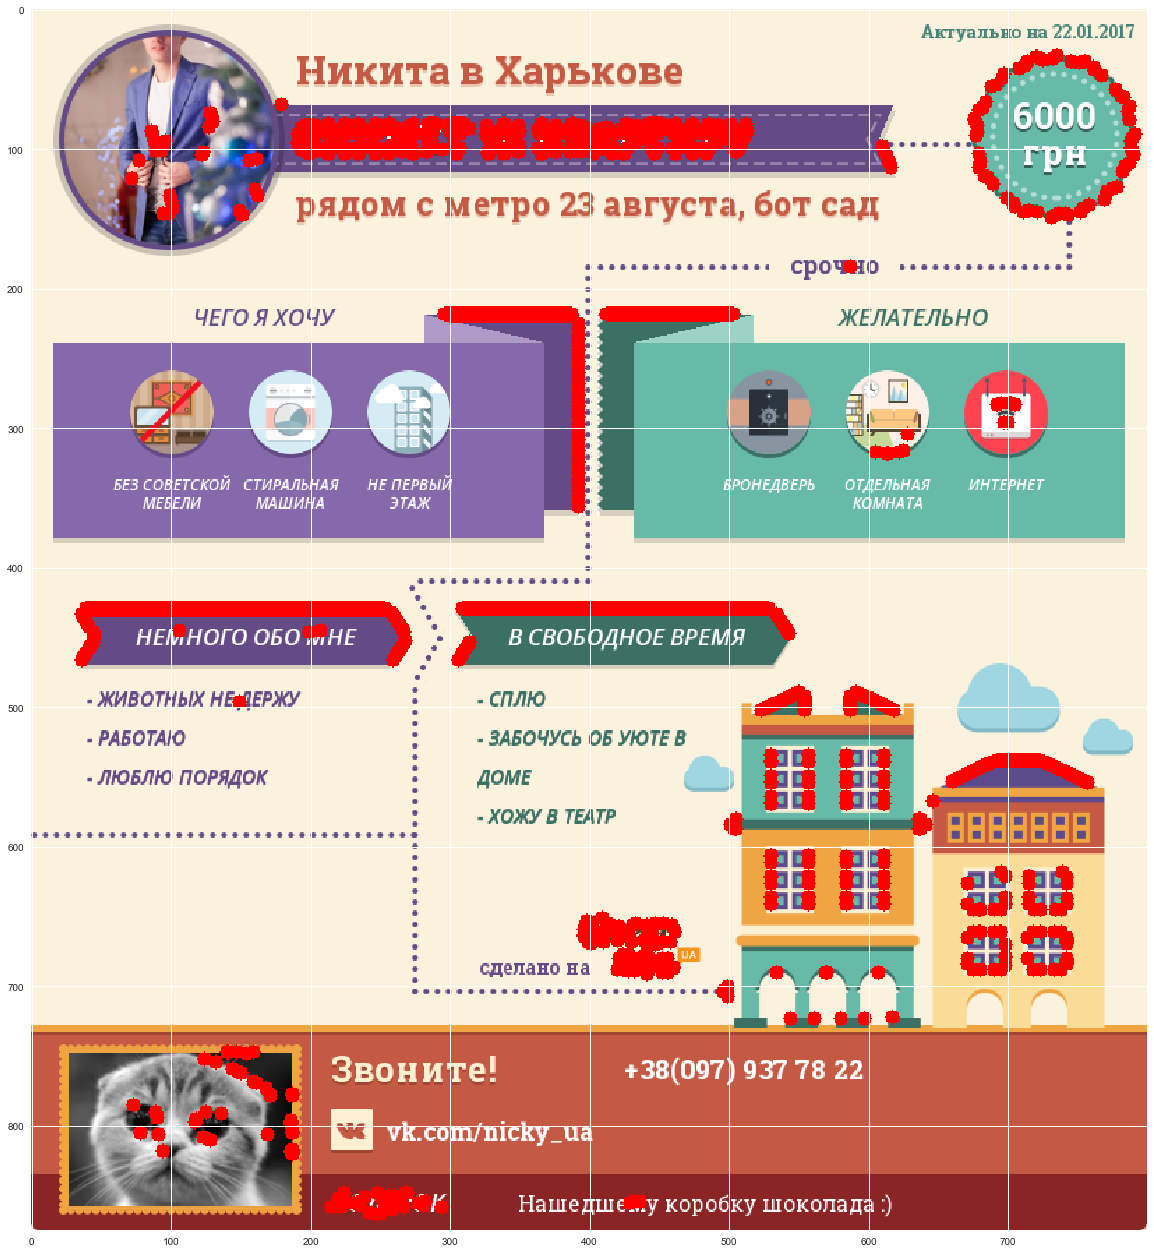

In [15]:
parent = []
sz = []
fimage, image,dx_img, dy_img, Gx, Gy, Gxy, L, points, i_points, m_parents = Harris_detector_2D("Desktop/img.png", (5, 5), 1.5)
#L *= 255.0/L.max()    
#plt.imshow(L, cmap = "gray")
print len(i_points)
plt.imshow(cv2.cvtColor(fimage, cv2.COLOR_BGR2RGB))

In [75]:
cap.release()

In [12]:
plt.imshow(cv2.cvtColor(fimage, cv2.COLOR_BGR2RGB))

NameError: name 'fimage' is not defined

In [300]:
fimage.shape

(875, 800)

In [1]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

NameError: name 'plt' is not defined

In [298]:
image.shape

(875, 800, 4)

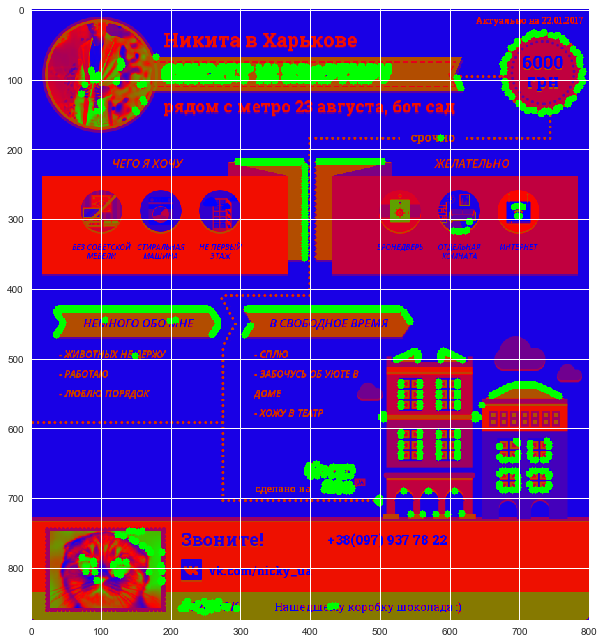

In [284]:
plt.imshow(fimage, cmap = plt.cm.brg_r)

In [128]:
colormaps()

NameError: name 'colormaps' is not defined

In [166]:
rgb_image = cv2.cvtColor(fimage, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(fimage, cv2.COLOR_BGR2RGB))

error: /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.cpp:9716: error: (-215) scn == 3 || scn == 4 in function cvtColor


In [342]:
len(i_points)

1839

In [326]:
points

{174763: 102,
 174764: 102,
 655386: 142,
 655387: 142,
 344070: 102,
 344071: 102,
 344072: 102,
 76467: 93,
 65589: 78,
 344073: 102,
 174772: 102,
 174775: 102,
 76472: 138,
 174779: 102,
 344081: 102,
 174780: 102,
 344082: 102,
 524398: 135,
 524401: 130,
 524402: 203,
 344083: 102,
 344084: 102,
 524412: 91,
 524413: 102,
 524414: 86,
 524415: 79,
 393345: 84,
 393346: 96,
 393347: 79,
 524423: 102,
 524424: 96,
 524425: 83,
 393354: 78,
 174786: 102,
 524432: 90,
 524433: 97,
 524434: 85,
 524442: 110,
 524443: 104,
 524444: 91,
 524445: 92,
 524446: 115,
 524447: 138,
 524448: 123,
 524449: 83,
 344091: 102,
 524453: 90,
 524454: 85,
 98473: 118,
 98474: 86,
 393387: 80,
 524460: 83,
 344093: 102,
 393395: 92,
 393396: 90,
 344094: 102,
 344095: 102,
 65729: 105,
 65730: 79,
 578943: 80,
 578944: 88,
 65797: 81,
 65798: 104,
 65799: 116,
 65800: 115,
 65801: 103,
 344109: 102,
 65811: 108,
 65812: 132,
 65813: 132,
 65814: 108,
 344111: 102,
 65823: 108,
 65824: 132,
 65825: 13

In [15]:
(219, 469) in points

True

In [14]:
points

{(219, 469),
 (792, 187),
 (281, 698),
 (219, 322),
 (661, 423),
 (777, 186),
 (85, 373),
 (68, 613),
 (87, 459),
 (642, 530),
 (94, 509),
 (99, 393),
 (89, 227),
 (218, 313),
 (627, 671),
 (658, 401),
 (218, 424),
 (94, 287),
 (69, 202),
 (688, 696),
 (69, 579),
 (655, 460),
 (89, 445),
 (99, 244),
 (84, 128),
 (430, 364),
 (69, 468),
 (89, 302),
 (776, 186),
 (795, 118),
 (83, 328),
 (430, 479),
 (69, 357),
 (93, 383),
 (98, 407),
 (83, 313),
 (102, 503),
 (68, 182),
 (435, 535),
 (69, 246),
 (808, 122),
 (685, 428),
 (98, 262),
 (101, 677),
 (102, 326),
 (429, 238),
 (68, 434),
 (430, 185),
 (429, 127),
 (68, 449),
 (611, 557),
 (429, 400),
 (68, 336),
 (68, 231),
 (430, 522),
 (103, 122),
 (722, 560),
 (606, 611),
 (96, 248),
 (813, 187),
 (684, 424),
 (690, 537),
 (90, 236),
 (219, 384),
 (47, 766),
 (219, 305),
 (544, 679),
 (123, 74),
 (68, 601),
 (90, 433),
 (218, 362),
 (747, 136),
 (89, 255),
 (90, 288),
 (553, 584),
 (549, 668),
 (747, 130),
 (688, 676),
 (429, 526),
 (819, 

In [410]:
i = 100
delta = 9

In [412]:
np.round(L[i:(i+delta), i:(i+delta)], 3)

array([[  9.00000000e-03,   1.56111000e+02,   2.33235300e+03,
          3.98651900e+03,   8.48104000e+02,   5.22000000e-01,
          3.19615000e+02,   1.88404200e+03,   1.66509300e+03],
       [  6.57900000e+01,   1.46306200e+03,   3.34148200e+03,
          1.09083400e+03,   3.42300000e+00,   1.50744000e+02,
          1.25827900e+03,   1.13643900e+03,   1.79262000e+02],
       [  8.58490000e+02,   2.34955600e+03,   1.09083400e+03,
          1.62230000e+01,   5.55020000e+01,   7.71605000e+02,
          6.60490000e+02,   9.49540000e+01,   1.29700000e+00],
       [  1.73056000e+03,   9.73787000e+02,   3.89930000e+01,
          1.30400000e+01,   3.84160000e+02,   4.29410000e+02,
          6.62420000e+01,   6.49000000e-01,   2.28300000e+00],
       [  9.38061000e+02,   8.11000000e+01,   2.57800000e+00,
          1.38324000e+02,   2.36818000e+02,   4.62400000e+01,
          6.40000000e-01,   4.82000000e-01,   1.67600000e+00],
       [  1.94293000e+02,   9.16700000e+00,   3.55350000e+01,
   

In [390]:
image[0, 0] / 2

121

In [391]:
print image[0:10, 0:10]

[[243 243 243 244 244 244 244 244 244 244]
 [243 243 243 244 244 244 244 244 244 244]
 [243 243 244 244 244 244 244 244 244 244]
 [244 244 244 244 244 244 244 244 244 244]
 [244 244 244 244 244 244 244 244 244 244]
 [244 244 244 244 244 244 244 244 244 244]
 [244 244 244 244 244 244 244 244 244 244]
 [244 244 244 244 244 244 244 244 244 244]
 [244 244 244 244 244 244 244 244 244 244]
 [244 244 244 244 244 244 244 244 244 244]]


In [392]:
np.max(L)

255.0

In [393]:
dy_img[0:4, 0:4]

array([[  0.00000000e+00,   0.00000000e+00,   7.10542736e-15,
          1.42108547e-14],
       [  0.00000000e+00,   1.66666667e-01,   1.66666667e-01,
          1.66666667e-01],
       [  5.00000000e-01,   5.00000000e-01,   3.33333333e-01,
          1.66666667e-01],
       [  5.00000000e-01,   3.33333333e-01,   1.66666667e-01,
         -1.42108547e-14]])

In [394]:
dx_img[0:4, 0:4]

array([[ 0.        ,  0.        ,  0.5       ,  0.5       ],
       [ 0.        ,  0.16666667,  0.5       ,  0.33333333],
       [ 0.        ,  0.16666667,  0.33333333,  0.16666667],
       [ 0.        ,  0.16666667,  0.16666667,  0.        ]])

In [395]:
i = 0
delta = 10
np.round(Gx[i:(i+delta), i:(i+delta)], 2)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.03,  0.25,  0.11,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.03,  0.11,  0.03,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.03,  0.03,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [142]:
np.min(image)

17

In [231]:
Gx[:10, :5]

array([[ 2.20417148,  2.68502638,  3.55215727,  3.29354158,  2.04509763],
       [ 2.00823069,  2.40132368,  3.11836029,  2.8634086 ,  1.75752214],
       [ 1.45722622,  1.66336269,  2.05760621,  1.83846342,  1.09076974],
       [ 0.85654937,  0.8919009 ,  0.99234804,  0.82604798,  0.44421446],
       [ 0.33708706,  0.32734296,  0.31947135,  0.24461184,  0.11384332],
       [ 0.08500568,  0.07757554,  0.06315672,  0.04250284,  0.01441882],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [131]:
abs_sobel64f[0:4, 0:4]

array([[  0.,  60.,  54.,  30.],
       [  0.,  54.,  43.,  20.],
       [  0.,  40.,  24.,   5.],
       [  0.,  24.,  12.,   0.]])

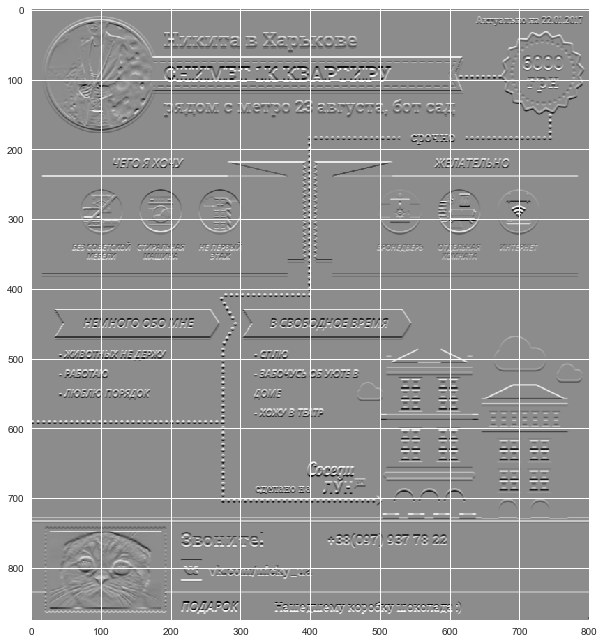

In [81]:
filename = "Desktop/img.png"
image = read_img(filename, True)
sobelx64f = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=3)
#abs_sobel64f = np.absolute(sobelx64f)
plt.imshow(sobelx64f)

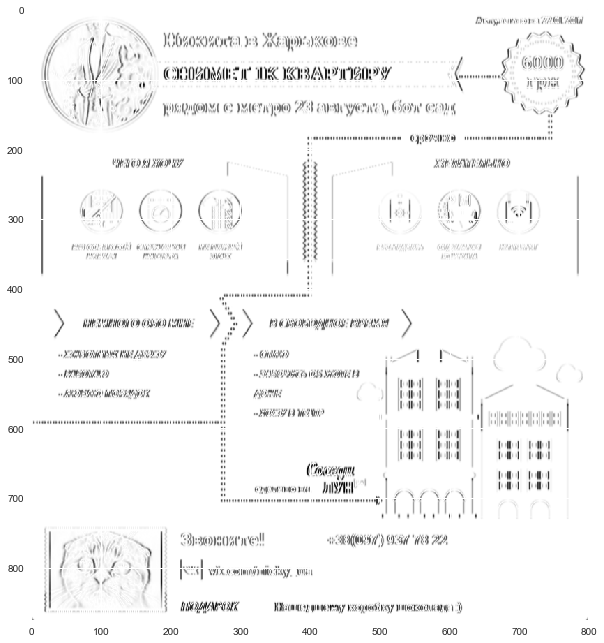

In [65]:
filename = "Desktop/img.png"
image = read_img(filename, True)
sobelx64f = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
plt.imshow(abs_sobel64f)

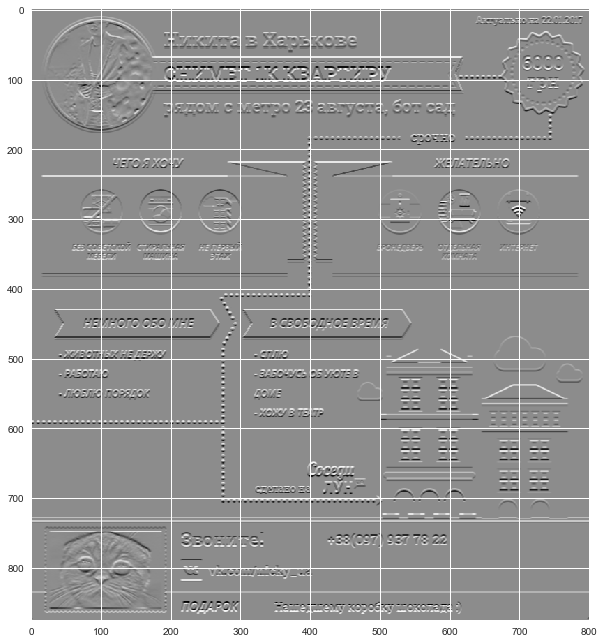

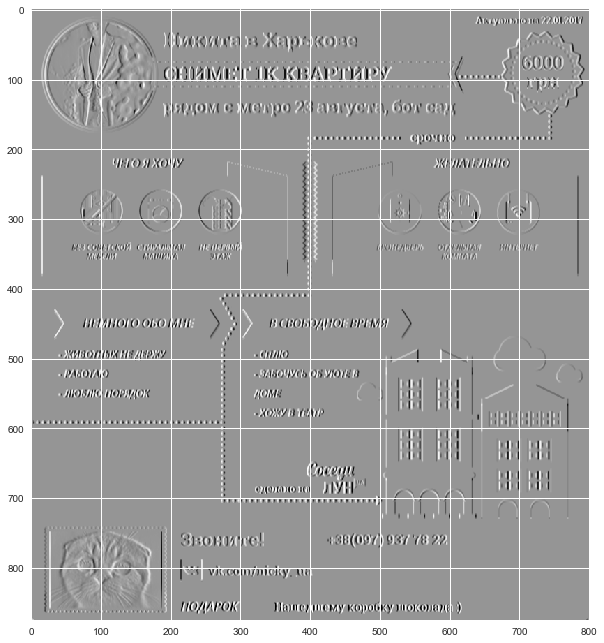

In [111]:
image = read_img(filename, True)

plt.imshow(new_img)
plt.show()
new_img1 = cv2.filter2D(image,cv2.CV_64F, horizontal_derivative_kernel)
plt.imshow(new_img1)
plt.show()

In [102]:
%%timeit -n3
Gx, Gy, Gxy = Harris_detector_2D("Desktop/2.jpg", (5, 5), 1.0)

(960, 720)
(960, 720)
(960, 720)
(960, 720)
(960, 720)
(960, 720)
(960, 720)
(960, 720)
(960, 720)
3 loops, best of 3: 896 ms per loop


In [34]:
gaussian_filter1d([1.0, 2.0, 1.0, 1.0], axis=0, sigma=3)



array([ 1.26101349,  1.25456136,  1.24544857,  1.23897658])

In [27]:
filename = "Desktop/2.jpg"


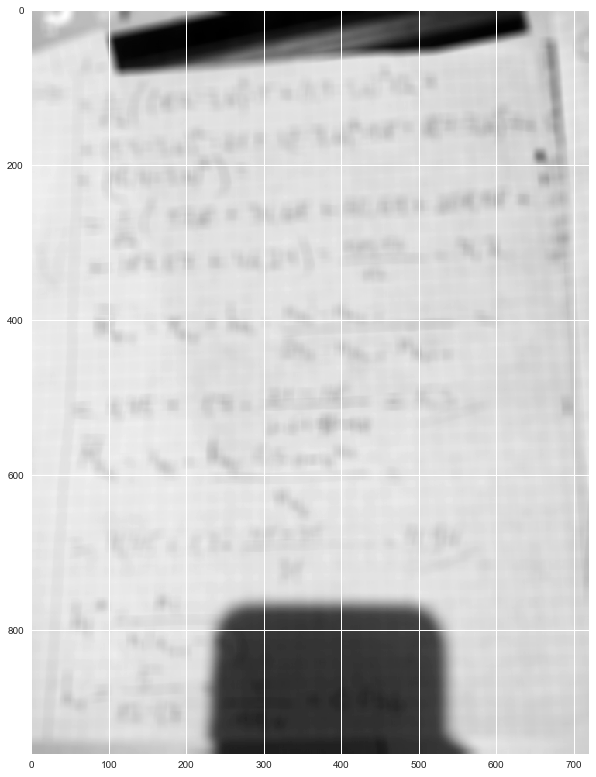

In [32]:
image = read_img(filename, True)
image = cv2.GaussianBlur(image, (15, 1), 10)
image = cv2.GaussianBlur(image, (1, 15), 10)
plt.imshow(image, cmap="gray")

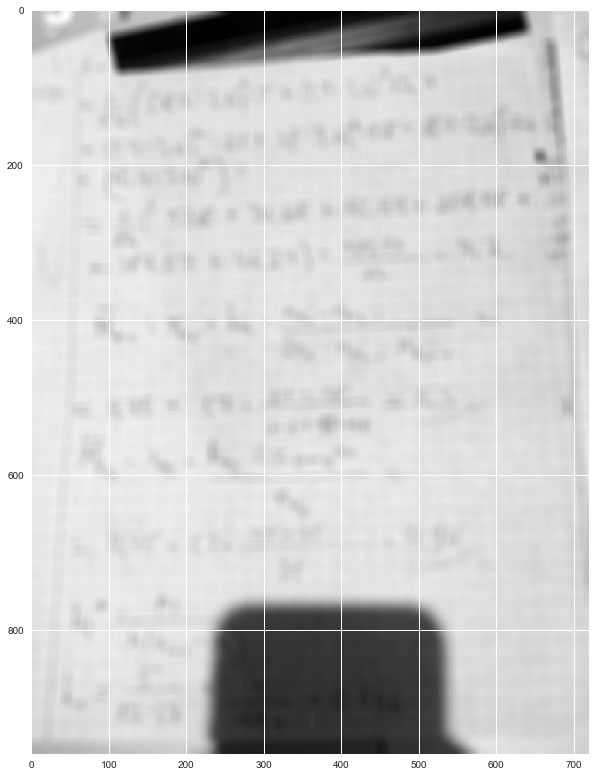

In [33]:
image = read_img(filename, True)
image = cv2.GaussianBlur(image, (15, 15), 10)
plt.imshow(image, cmap="gray")

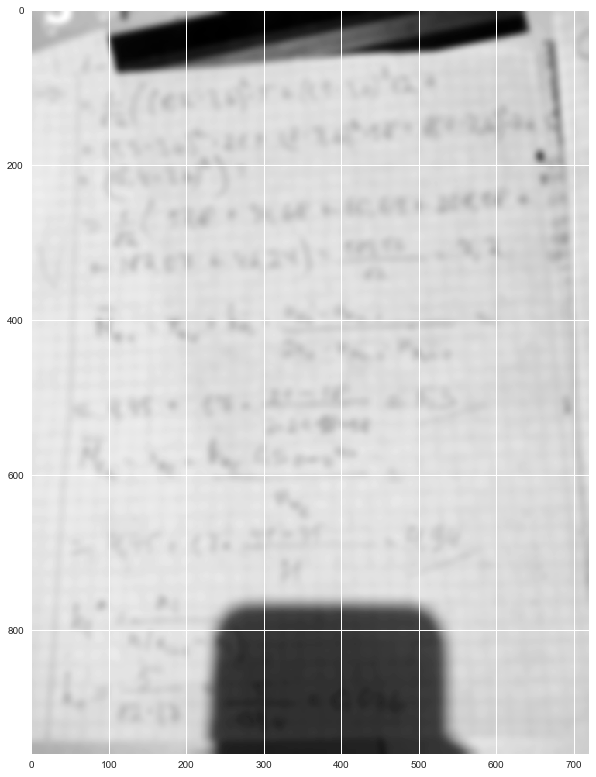

In [90]:
image = cv2.GaussianBlur(image, (7, 7), 0)
plt.imshow(image, cmap = 'gray')


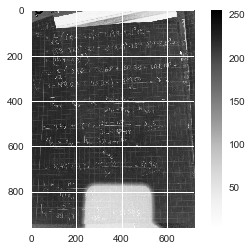

In [70]:
imgplot = plt.imshow(image)
plt.colorbar()


(array([  4.00000000e+00,   3.00000000e+00,   1.10000000e+01,
          5.90000000e+01,   1.44000000e+02,   8.32000000e+02,
          1.31700000e+03,   3.42300000e+03,   2.68500000e+03,
          3.13200000e+03,   1.61000000e+03,   1.76900000e+03,
          8.89000000e+02,   1.24900000e+03,   6.89000000e+02,
          1.14900000e+03,   9.64000000e+02,   1.67500000e+03,
          1.31100000e+03,   2.02500000e+03,   1.53300000e+03,
          3.36300000e+03,   3.51400000e+03,   7.68900000e+03,
          6.59100000e+03,   1.01180000e+04,   7.78900000e+03,
          3.57100000e+03,   3.49300000e+03,   1.56900000e+03,
          1.51400000e+03,   7.14000000e+02,   7.81000000e+02,
          4.14000000e+02,   5.34000000e+02,   4.50000000e+02,
          6.49000000e+02,   4.62000000e+02,   6.97000000e+02,
          4.94000000e+02,   7.82000000e+02,   6.00000000e+02,
          8.96000000e+02,   6.43000000e+02,   9.32000000e+02,
          6.53000000e+02,   1.04500000e+03,   6.47000000e+02,
        

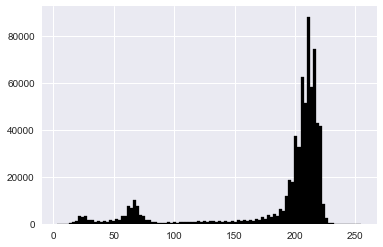

In [71]:
plt.hist(image.ravel(), bins=100, fc='k', ec='k')

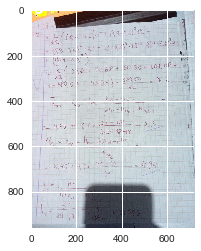

In [72]:
plt.imshow(img)


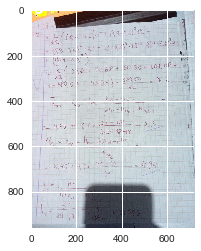

In [73]:
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [8]:
print "Height:\t\t%i pixels\nWidth:\t\t%i pixels\nChannels:\t%i" % img.shape


NameError: name 'img' is not defined